### Mall Customers

##### Notebook

- Acquire data from the customers table in the mall_customers database.
- Summarize the data (include distributions and descriptive statistics).
- Detect outliers using IQR.
- Split data into train, validate, and test.
- Encode categorical columns using a one hot encoder (pd.get_dummies).
- Handles missing values.
- Scaling

In [1]:
# Environment Set up
import pandas as pd
import numpy as np
from env import user, password, host,get_db_url
import wrangle_zillow
import seaborn as sns
import os
import env
from imports import *


In [2]:
def get_connection(db, user=user, host=host,password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
query = """ SELECT * FROM customers; """

In [4]:
def acquire_mall():
    """ Acquire mall customer data from mySQL server or cached csv, returns as Pandas DataFrame """
    
    if os.path.exists('mall_customers.csv'):
        print("Using cached data")
        mall = pd.read_csv('mall_customers.csv')
    # Acquire data from database if CSV does not exist
    else:
        print("Acquiring data from server")
        query = """ SELECT * FROM customers; """
        mall = pd.read_sql(query, get_connection('mall_customers'))
        
        mall.to_csv('mall_customers.csv', index=False)
        
    
    return mall

In [5]:
mall=acquire_mall()

Using cached data


In [6]:
mall.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


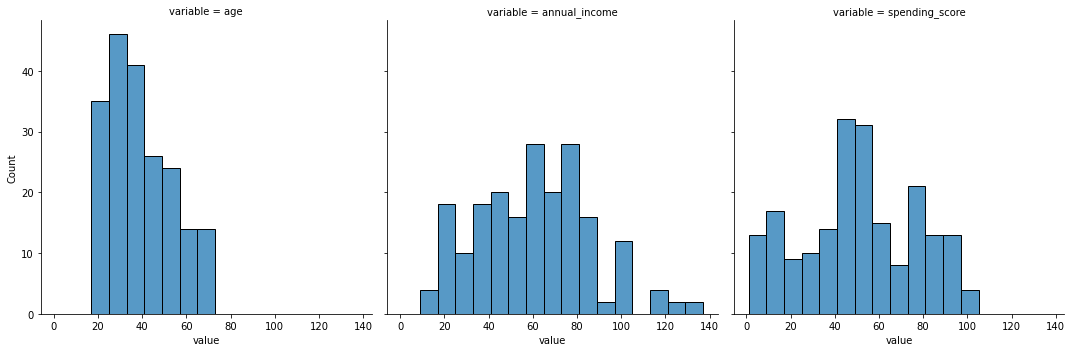

In [7]:
sns.displot(data = mall[['age','annual_income','spending_score']].melt(), col = 'variable', x='value')

In [8]:
# df=mall
# def get_upper_outliers(s, k):
#     '''
#     Given a series and a cutoff value, k, returns the upper outliers for the
#     series.
    
#     The values returned will be either 0 (if the point is not an outlier), or a
#     number that indicates how far away from the upper bound the observation is.
#     '''
#     q1, q3 = s.quantile([.25, .75])
#     iqr = q3 - q1
#     upper_bound = q3 + k * iqr
#     return s.apply(lambda x: max([x - upper_bound, 0]))

# def add_upper_outlier_columns(df, k):
#     '''
#     Add a column with the suffix _outliers for all the numeric columns
#     in the given dataframe.
#     '''
#     # outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
#     #                 for col in df.select_dtypes('number')}
#     # return df.assign(**outlier_cols)
    
#     for col in df.select_dtypes('number'):
#         df[col + '_outliers'] = get_upper_outliers(df[col], k)
        
#     return df

# add_upper_outlier_columns(df, k=1.5)

# df.head()

In [9]:
def remove_outliers(df, k, col_list):
    ''' Removes outliers based on multiple of IQR. Accepts as arguments the dataframe, the k value for number of IQR to use as threshold, and the list of columns. Outputs a dataframe without the outliers.
    '''
    # Create a column that will label our rows as containing an outlier value or not
    num_obs = df.shape[0]
    df['outlier'] = False
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # update the outlier label any time that the value is outside of boundaries
        df['outlier'] = np.where(((df[col] < lower_bound) | (df[col] > upper_bound)) & (df.outlier == False), True, df.outlier)
    
    df = df[df.outlier == False]
    df.drop(columns=['outlier'], inplace=True)
    print(f"Number of observations removed: {num_obs - df.shape[0]}")
        
    return df

In [10]:
# def summary_info(df): 
#     # Summarize data (shape, info, summary stats, dtypes, shape)
#     print('--- Shape: {}'.format(df.shape))
#     print('--- Descriptions')
#     print(df.describe(include='all'))
#     print('--- Info')
#     return df.info()

In [11]:
col_list = ['gender','age','annual_income','spending_score']
remove_outliers(mall, k=1.5, col_list=['age','annual_income','spending_score'])

Number of observations removed: 2


,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
193,194,Female,38,113,91
194,195,Female,47,120,16
195,196,Female,35,120,79
196,197,Female,45,126,28


In [12]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

def split_data(df, train_size_vs_train_test = 0.8, train_size_vs_train_val = 0.7, random_state = 123):
    """Splits the inputted dataframe into 3 datasets for train, validate and test (in that order).
    Can specific as arguments the percentage of the train/val set vs test (default 0.8) and the percentage of the train size vs train/val (default 0.7). Default values results in following:
    Train: 0.56
    Validate: 0.24
    Test: 0.2"""
    train_val, test = train_test_split(df, train_size=train_size_vs_train_test, random_state=123)
    train, validate = train_test_split(train_val, train_size=train_size_vs_train_val, random_state=123)
    
    train_size = train_size_vs_train_test*train_size_vs_train_val
    test_size = 1 - train_size_vs_train_test
    validate_size = 1-test_size-train_size
    
    print(f"Data split as follows: Train {train_size:.2%}, Validate {validate_size:.2%}, Test {test_size:.2%}")
    
    return train, validate, test

def scale_data(train, validate, test, features_to_scale):
    """Scales data using MinMax Scaler. 
    Accepts train, validate, and test datasets as inputs as well as a list of the features to scale. 
    Returns dataframe with scaled values added on as columns"""
    
    # Fit the scaler to train data only
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(train[features_to_scale])
    
    # Generate a list of the new column names with _scaled added on
    scaled_columns = [col+"_scaled" for col in features_to_scale]
    
    # Transform the separate datasets using the scaler learned from train
    scaled_train = scaler.transform(train[features_to_scale])
    scaled_validate = scaler.transform(validate[features_to_scale])
    scaled_test = scaler.transform(test[features_to_scale])
    
    # Concatenate the scaled data to the original unscaled data
    train_scaled = pd.concat([train, pd.DataFrame(scaled_train,index=train.index, columns = scaled_columns)],axis=1)
    validate_scaled = pd.concat([validate, pd.DataFrame(scaled_validate,index=validate.index, columns = scaled_columns)],axis=1)
    test_scaled = pd.concat([test, pd.DataFrame(scaled_test,index=test.index, columns = scaled_columns)],axis=1)

    return train_scaled, validate_scaled, test_scaled

def wrangle_mall():
    """ Acquires, encodes gender, splits, and scales data from mall customers. Returns 3 dataframes """
    
    mall = acquire_mall()
    
    # Encode gender
    mall = pd.get_dummies(mall, columns=['gender'], drop_first=True)
    
    # Split data
    
    train, validate, test = split_data(mall)
    
    # Scale data
    
    train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, ['age','annual_income','spending_score'])
    
    return train_scaled, validate_scaled, test_scaled

In [13]:
train, validate, test = wrangle_mall()

Using cached data
Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,112.00,99.34,57.29,1.00,49.50,101.00,148.25,200.00
age,112.00,38.42,14.59,18.00,27.00,35.50,48.00,70.00
annual_income,112.00,60.25,26.36,15.00,40.00,61.50,77.25,137.00
spending_score,112.00,52.04,24.16,1.00,35.75,50.00,73.25,95.00
gender_Male,112.00,0.38,0.49,0.00,0.00,0.00,1.00,1.00
age_scaled,112.00,0.39,0.28,0.00,0.17,0.34,0.58,1.00
annual_income_scaled,112.00,0.37,0.22,0.00,0.20,0.38,0.51,1.00
spending_score_scaled,112.00,0.54,0.26,0.00,0.37,0.52,0.77,1.00


In [15]:
mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
 5   outlier         200 non-null    bool  
dtypes: bool(1), int64(4), object(1)
memory usage: 8.1+ KB


In [16]:
mall.head()

,customer_id,gender,age,annual_income,spending_score,outlier
0,1,Male,19,15,39,False
1,2,Male,21,15,81,False
2,3,Female,20,16,6,False
3,4,Female,23,16,77,False
4,5,Female,31,17,40,False


In [17]:
train.head()

,customer_id,age,annual_income,spending_score,gender_Male,age_scaled,annual_income_scaled,spending_score_scaled
123,124,39,69,91,1,0.40,0.44,0.96
76,77,45,54,53,0,0.52,0.32,0.55
171,172,28,87,75,1,0.19,0.59,0.79
10,11,67,19,14,1,0.94,0.03,0.14
35,36,21,33,81,0,0.06,0.15,0.85
